In [1]:
import numpy as np
import gym
import torch as T
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [2]:
def plot(total_rewards):
    clear_output(True)
    smoothed_rewards = [np.mean(total_rewards[max(0,i-10):i+1]) for i in range(len(total_rewards))]
    plt.plot(total_rewards, label = 'episodic reward')
    plt.plot(smoothed_rewards, label = 'mean reward')
    plt.title("CartPole Rewards using REINFORCE with Policy Baseline")
    plt.xlabel("Episode")
    plt.ylabel("Rewards")
    plt.legend()
    plt.show()

In [3]:
env = gym.make('CartPole-v0')

In [4]:
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 32), 
            nn.ReLU(), 
            nn.Linear(32, self.n_outputs),
            nn.Softmax(dim=-1))
        
    def forward(self, state):
        state = T.FloatTensor(state)
        action_probs = self.network(state)
        return action_probs

In [5]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(),lr=0.01)
action_space = np.arange(env.action_space.n)

In [6]:
def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    # subtract average reward i.e. taking avg reward as baseline
    r = r - r.mean()
    return r

In [7]:
def policy_update(batch_states, batch_rewards, batch_actions):
    optimizer.zero_grad()
    state_tensor = T.FloatTensor(batch_states)
    reward_tensor = T.FloatTensor(batch_rewards)
    action_tensor = T.LongTensor(batch_actions)

    # Calculate loss
    logprob = T.log(policy(state_tensor))
    selected_logprobs = reward_tensor * logprob.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
    loss = -selected_logprobs.mean()

    # calculate and update gradients
    loss.backward()
    optimizer.step()

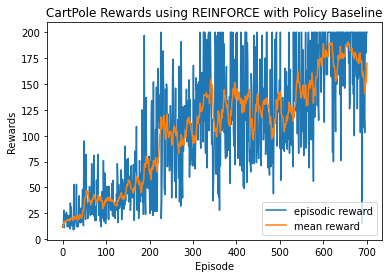

In [8]:
total_rewards = []
batch_rewards = []
batch_actions = []
batch_states = []
batch_counter = 1
batch_size = 10
num_episodes = 800
gamma=0.99


for ep in range(num_episodes):
    state = env.reset()
    state_list = []
    reward_list = []
    action_list = []
    done = False
    while not done:
        action_probs = policy(state).detach().numpy()
        action = np.random.choice(action_space, p = action_probs)
        next_state, reward, done, _ = env.step(action)
        
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward)
        state = next_state
        

    batch_rewards.extend(discount_rewards(reward_list, gamma))
    batch_states.extend(state_list)
    batch_actions.extend(action_list)
    batch_counter += 1
    total_rewards.append(sum(reward_list))
    
    if batch_counter == batch_size:
        policy_update(batch_states, batch_rewards, batch_actions)
        batch_rewards = []
        batch_actions = []
        batch_states = []
        batch_counter = 1
        
    if ep % 100 == 0:
        plot(total_rewards)
    
    